In [1]:
from metrics import score, accuracies, confusion_matrix
from DecisionTreeBuilder import create_decision_tree
from titanic import get_data, get_graphviz
import matplotlib.pyplot as plt
from RandomForest import RandomForestClassifier

from IPython.display import HTML
import random

def hide_toggle(title="", for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = f'Mostrar/ocultar celda: {title}'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle("Imports")

### Ingreso de datos
Definimos las funciones para hacer data cleansing y normalizar los atributos 

In [2]:
def age_discretization(age):
    try:
        age = int(age)
        cutoffs = ['20', '40', '60']
        for c in cutoffs:
            if age < int(c):
                return '<' + c
        return cutoffs[-1] + '+'
    except:
        return None

def cabin_discretize(cabin):
    try:
        return cabin[0]
    except:
        return None


def survival_transform(s):
    s = int(s)
    return "Sobrevive" if s == 1 else "Muere"

hide_toggle("Funciones de transformacion")

### Selección de columnas
El vector `attributes` indicará que columnas del CSV tomamos para los datos.
Se define para cada uno un nombre, el indice de la columna y la funcion para transformar
la columna (para normalizar)

In [3]:
attributes = [
    {  "name": "clase",
       "idx": 2,
       "transform": lambda x: x
    },
    {  "name": "sexo",
       "idx": 4,
       "transform": lambda x: x
    },
    {  "name": "edad",
       "idx": 5,
       "transform": age_discretization
    },
#       {  "name": "cabin",
#           "idx": 10,
#           "transform": cabin_discretize
#        },
 #       {  "name": "sibsp",
 #          "idx": 6,
 #          "transform": lambda x: x
 #       },
    {  "name": "supervivencia",
       "idx": 1,
       "transform": survival_transform
    }
]
hide_toggle("Atributos")

In [4]:
FILENAMES = ['titanic.csv', 'kaggle/train.csv']
SEPARATORS = ['\t', ',']
CHOICE = 1
x, y, metadata = get_data(FILENAMES[CHOICE], SEPARATORS[CHOICE], attributes)

### Definimos las constantes

In [5]:
TRAIN_RATIO = 0.3
BOOTSTRAP_RATIO = 1

### Dividimos en test y train

In [6]:
def reload_data(train_ratio):
    global train_x, test_x, train_y, test_y
    test_size = int(len(x) * (1-train_ratio))
    train_x = x[0:-test_size]
    test_x = x[-test_size:]
    train_y = y[0:-test_size]
    test_y = y[-test_size:]

hide_toggle("Separación test/train")

In [7]:
reload_data(TRAIN_RATIO)
print("Train size: ", len(train_x), " test size: ", len(test_x))

Train size:  207  test size:  482


In [8]:
def decision_tree(info_function, max_iterations=10000):
    return create_decision_tree(x = train_x, y = train_y, 
                                metric_f_name = info_function, 
                                max_iterations=max_iterations)
    
def random_forest(n_trees, info_function):
    rf = RandomForestClassifier(n_trees, bootstrap_size = BOOTSTRAP_RATIO, metric_f = info_function)
    rf.fit(train_x, train_y)
    return rf

hide_toggle("Utility functions para crear arboles")

# Visualizando los árboles de decisión

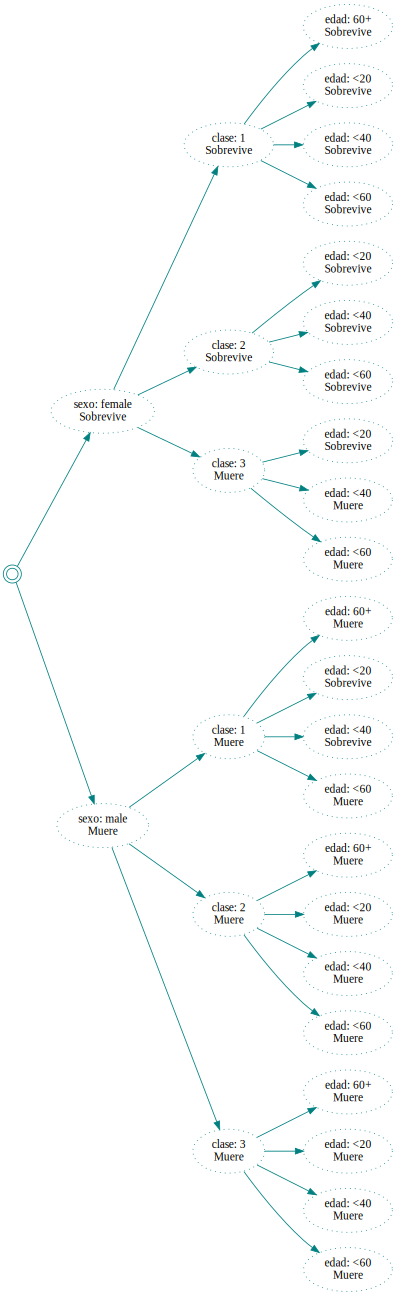

In [9]:
reload_data(0.3)
t = decision_tree(info_function = 'gain', max_iterations=100000)
g = get_graphviz(t, metadata, 'rankdir="LR";size="18";node [shape="oval", style=dotted, color=teal];edge [color=teal]')
reload_data(TRAIN_RATIO)
g

## Matrices de confusion
### 1. Utilizando arboles de decision con ganancia de informacion

* Class: Muere
Accuracy 0.78631 | Precision 0.78125 | Recall 0.88339 | TP-rate 0.88339 | FP-rate 0.35176 | F1 0.82919 

* Class: Sobrevive
Accuracy 0.78631 | Precision 0.79630 | Recall 0.64824 | TP-rate 0.64824 | FP-rate 0.11661 | F1 0.71468 

HARMONIC MEANS

    Accuracy: 0.78631
    Precision: 0.78870
    Recall: 0.74777
    TP rate: 0.74777
    FP rate: 0.17515
    F1 score: 0.76769


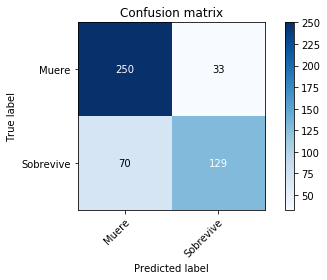

In [10]:
t = decision_tree('gain')
score(t, test_x, test_y, metadata[-1]['values'], confusion_matrix = True, normalize=False)
hide_toggle()

### 2. Utilizando arboles de decision con coeficiente gini

* Class: Muere
Accuracy 0.78631 | Precision 0.78125 | Recall 0.88339 | TP-rate 0.88339 | FP-rate 0.35176 | F1 0.82919 

* Class: Sobrevive
Accuracy 0.78631 | Precision 0.79630 | Recall 0.64824 | TP-rate 0.64824 | FP-rate 0.11661 | F1 0.71468 

HARMONIC MEANS

    Accuracy: 0.78631
    Precision: 0.78870
    Recall: 0.74777
    TP rate: 0.74777
    FP rate: 0.17515
    F1 score: 0.76769


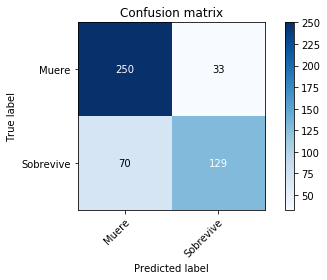

In [11]:
t = decision_tree('gini')
confusion_matrix(t, test_x, test_y, metadata[-1]['values'])
score(t, test_x, test_y, metadata[-1]['values'])
hide_toggle()

### 3. Utilizando random forest con ganancia de información

* Class: Muere
Accuracy 0.78216 | Precision 0.73797 | Recall 0.97527 | TP-rate 0.97527 | FP-rate 0.49246 | F1 0.84018 

* Class: Sobrevive
Accuracy 0.78216 | Precision 0.93519 | Recall 0.50754 | TP-rate 0.50754 | FP-rate 0.02473 | F1 0.65798 

HARMONIC MEANS

    Accuracy: 0.78216
    Precision: 0.82495
    Recall: 0.66763
    TP rate: 0.66763
    FP rate: 0.04710
    F1 score: 0.73800


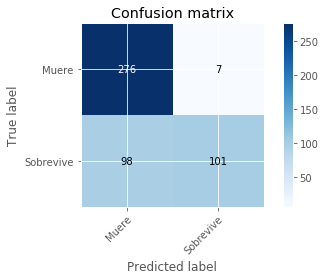

In [16]:
rf = random_forest(20, 'gain')
confusion_matrix(rf, test_x, test_y, metadata[-1]['values'])
score(rf, test_x, test_y, metadata[-1]['values'])
hide_toggle()

### 4. Utilizando random forest con ganancia de información

* Class: Muere
Accuracy 0.78216 | Precision 0.73797 | Recall 0.97527 | TP-rate 0.97527 | FP-rate 0.49246 | F1 0.84018 

* Class: Sobrevive
Accuracy 0.78216 | Precision 0.93519 | Recall 0.50754 | TP-rate 0.50754 | FP-rate 0.02473 | F1 0.65798 

HARMONIC MEANS

    Accuracy: 0.78216
    Precision: 0.82495
    Recall: 0.66763
    TP rate: 0.66763
    FP rate: 0.04710
    F1 score: 0.73800


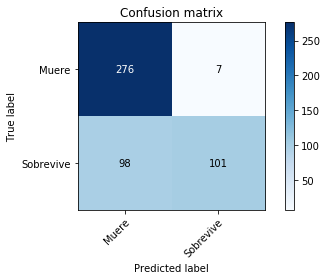

In [13]:
rf = random_forest(10, 'gini')
confusion_matrix(rf, test_x, test_y, metadata[-1]['values'])
score(rf, test_x, test_y, metadata[-1]['values'])
hide_toggle()

In [14]:
def acc_vs_nodes(train_size):
    plt.style.use("ggplot")
    plt.figure(figsize=(15,7))
    reload_data(train_size)
    plt.title(f"Train size = {len(train_x)} ({train_size*100}%)")
    plt.plot(*accuracies([decision_tree('gain', i) for i in range(1,50)], 
        train_x, train_y, metadata[-1]["values"]), '.-b', label="Train")
    plt.plot(*accuracies([decision_tree('gain', i) for i in range(-1,30)], 
        test_x, test_y, metadata[-1]["values"]), '.-r', label="Test")
#    plt.plot(*accuracies([decision_tree('gini', i) for i in range(1,50)], 
#        train_x, train_y, metadata[-1]["values"]), '.-g', label="Train")
#    plt.plot(*accuracies([decision_tree('gini', i) for i in range(-1,30)], 
#        test_x, test_y, metadata[-1]["values"]), '.-y', label="Test")
    plt.legend(loc='best', fontsize=20)
    plt.xlabel("Cantidad de nodos")
    plt.ylabel("Precisión")
    plt.ylim((0.4,1))
    plt.xlim((0,100))
    plt.show()
    reload_data(TRAIN_RATIO)
hide_toggle("Funcion para graficar accuracy vs nodes")

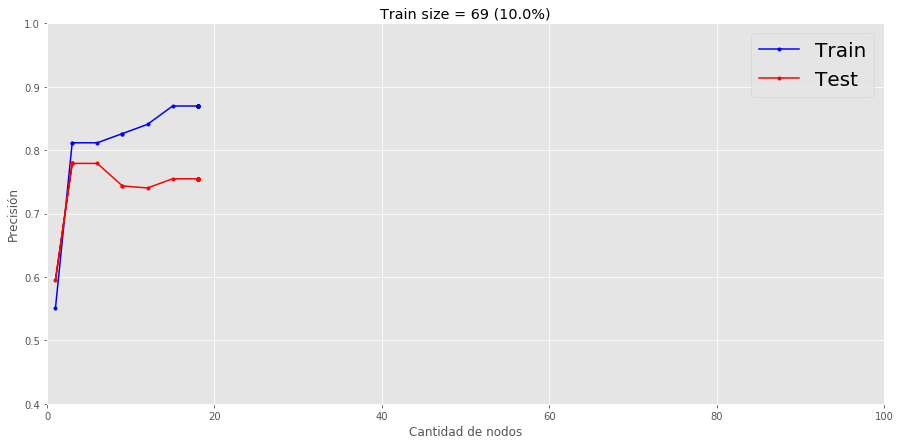

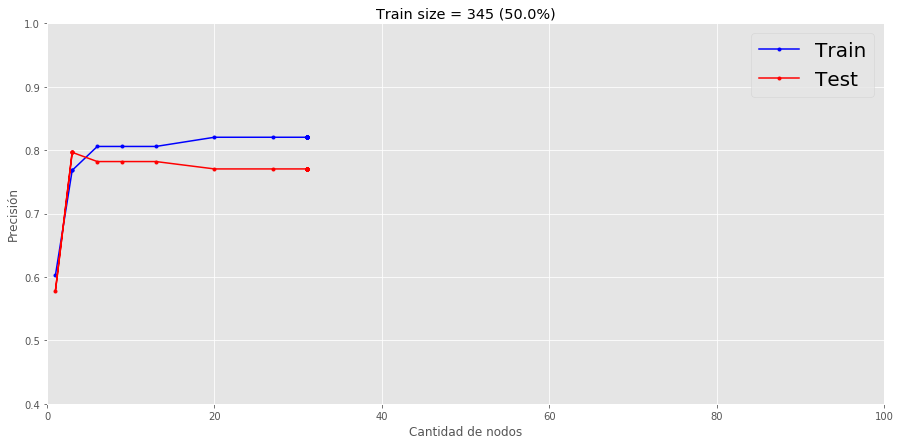

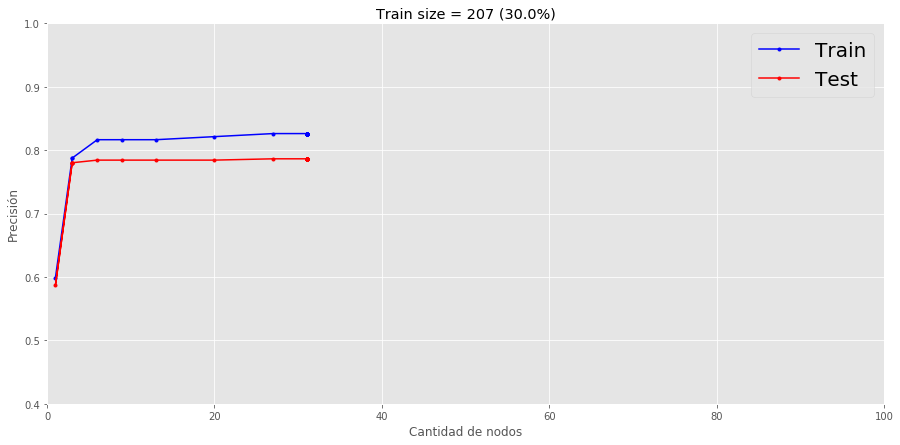

In [17]:
acc_vs_nodes(0.1)
acc_vs_nodes(0.5)
acc_vs_nodes(TRAIN_RATIO)